<a href="https://colab.research.google.com/github/lucascarter0/data-science-tools/blob/master/Covid19_Modeling_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling of Coronavirus Pandemic Using Markov-Chain Monte Carlo
This analysis attempts to create epidemiological models to better understand the behavior of coronavirus. Model parameters are estimated against observed United States case data using Markov Chain Monte Carlo. These model parameters are then propagated forward in time to observe the long-term behavior of the virus.*

*It should be noted that any forecasts from this analysis are not considered official in any capacity and are simple estimates.

#Introduction

Since its discovery in China in December 2019, the novel coronavirus SARS-CoV-2 has infected over 4 million people worldwide and accounted for over 300 thousand deaths [1]. To better understand the behavior of the virus in its early stages of research, scientists and elected officials are utilizing probabilistic modeling to attempt to represent the spread of the virus and estimate its potential impact. While these models are highly sophisticated and regularly updated, they are not always easily accessible to the general public, especially at the county or state level. This report attempts to recreate some of the basic probabilistic modeling assumptions used to represent the spread of coronavirus in the state of Texas. An overview of the dynamics that govern the spread of infectious disease is introduced, followed by an introduction to the Markov Chain Monte Carlo probabilistic modeling technique to estimate parameters of the infectious disease dynamics based on observed data. This technique is then applied to coronavirus case numbers reported by the state of Texas for the month of April 2020.

# Infectious Disease Dynamics 
Time dependent ordinary differential equations have been used to successfully model infectious diseases since the early 20th century [2]. These models have evolved to capture various assumptions and features [3][4], but originate from a basic SIR model first proposed by Kermack and McKendrick. 

The SIR model is a compartmental model that assumes a population is segmented into three proportions:
- Those that are susceptible to contracting the virus (S)
- Those that are infected with the virus (I)
- Those that are removed from exposure, meaning they are unable to transmit or recontract the virus, either recovered or dead (R).

The ordinary differential equations that govern the SIR model are

\begin{equation*}
\frac{dS}{dt} = -\beta I S \\
\frac{dI}{dt} = \beta I S - \gamma I \\
\frac{dR}{dt} = \gamma I
\end{equation*}

where $\beta$ is the average number of contacts per person per time and $\gamma$ is the rate of removal per unit time. The system assumes that the population is a closed system with equal birth and death rates where $S+I+R=1$.


# Markov Chain Monte Carlo

The SIR model is viewed in a deterministic sense, while the parameters that define its behavior are considered random values.

This assumption can be leveraged to apply Markov Chain Monte Carlo (MCMC) methods to model the dynamics of the system. MCMC is a Bayesian estimation technique that seeks to represent a set of observations by sampling from a prior distribution of each parameter and then evaluating it against the observation. It refines its sampling based purely on the sample at the previous time step, meaning the dynamics of the MCMC sampling can be thought of as a Markov process with probability [4]

\begin{equation*}
P(X_{n+1} = x | X_1 = x_1, X_2 = x_2,..., X_n = x_n) = P(X_{n+1} = x | X_n = x_n)
\end{equation*}

At each step in the MCMC sampling, a posterior distribution is estimated to be proportional to a prior distribution of the system parameters, an observation, and the likelihood that the sample represents the observation as defined by Bayes Theorem [5].

\begin{equation*}
P(A | X) \propto P(X|A)P(A)
\end{equation*}

 The algorithm then refines its sampling estimate. Over numerous samples, the prior system distributions will ideally converge to the represent the true probability distribution of the systemb

The goal of using MCMC in the context of coronavirus modeling will be to estimate the parameters $\beta$ and $\gamma$ in order to forecast future behavior of the coronavirus pandemic in Texas.

# Data Collection

Data used for this analysis comes from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19). The repository contains time history and data summary entries at the global level and United States state and county levels.

The initial goal of the analysis was to create a model using US county data, but recovered cases are not provided at that resolution. Data was instead collected for the state of Texas between the dates of April 12th and May 12th.The code below creates a single dataframe of confirmed, recovered, and active cases, as well as deaths.

In [0]:
# Load Required Libraries
!pip install pymc3==3.8
import os
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from datetime import timedelta, date

%matplotlib inline
plt.style.use('bmh')

In [0]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def load_county_data(state='Texas',population=2636000):

  df = pd.DataFrame(columns=['Confirmed','Deaths','Recovered','Active','People_Tested'])
  start_date = date(2020, 4, 12)
  end_date = date(2020, 5, 13)
  dates = [ii.strftime('%m-%d-%Y') for ii in daterange(start_date, end_date)]

  for single_date in dates:
      #day = single_date.strftime('%m-%d-%Y')
      basepath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us'
      url = os.path.join(basepath, '{}.csv'.format(single_date))

      a = pd.read_csv(url, index_col=0, usecols=['Province_State','Confirmed','Deaths','Recovered','Active','People_Tested'])

      df.loc[single_date] = a.loc[state]
  df.index = pd.to_datetime(df.index)
  # Normalize by population
  df = df.apply(lambda x : np.divide(x, population))
  return df.astype('float64')

# NOTE: Numbers are scaled for population
df = load_county_data(population=29000000)
df.tail()

,Confirmed,Deaths,Recovered,Active,People_Tested
2020-05-08,0.001284,0.000035,0.000662,0.000587,0.016452
2020-05-09,0.001324,0.000037,0.000695,0.000593,0.016872
2020-05-10,0.001354,0.000038,0.000725,0.000591,0.017303
2020-05-11,0.001398,0.000039,0.000749,0.000611,0.018127
2020-05-12,0.001429,0.000040,0.000749,0.000640,0.018127


#SIR Estimation

Parameters $\beta$ and $\gamma$ were chosen to have uniform distributions in an attempt to be uninformed, meaning there are no assumptions made about the distribution of the prior. These priors were then refined to lower and upper bounds based on intuition and historical parameters for other infectious diseases [6]. The two parameters were related by an estimated reproduction number for the virus $R_0$.

Cases of infected and removed individuals are modeled by a Beta distribution based on [7], where the parameters of the distribution are defined by the dynamics of the SIR model at time $t$.

The figure below highlights the dependence of the SIR model, and ultimately the observations, on the prior distributions of the parameters.

Compiling Parameter Priors
Compiling SEIR Dynamics
Compiling Observation Models


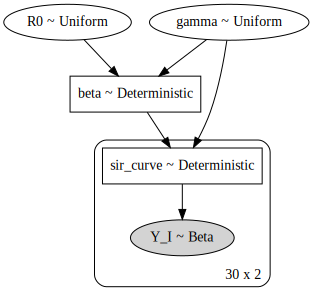

In [0]:
# Define SIR dynamics
def SIR(y, t, p):
    # p - beta, gamma, delta
    beta, gamma, N = p
    S,I,R = y
    ds = -beta*(S*I/N)
    di = beta*I*(S/N) - gamma*I
    dr = gamma*I
    return [ds, di, dr]

# Theano wrapper function to pass PYMC3 samples to custom dynamics function
@theano.compile.ops.as_op(
    itypes=[tt.dvector, tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar],
    otypes=[tt.dmatrix])
def sir_wrapper(times, initial_conditions, beta, gamma, N):
  y = odeint(SIR, y0=initial_conditions, t=times, args=((beta,gamma,N),))
  return y[:,[1,2]] # Index 1, returning estimated infected rates

# Observation data converted to ndarray for PYMC
yobs = pd.DataFrame(data=[df['Confirmed'], df['Recovered']+df['Deaths']]).transpose().to_numpy(dtype='float64')
# Creating array of times from y_t0+1 to y_t
times = np.arange(1, len(yobs), step=1, dtype='float64')

N = 1.0
(I, R) = yobs[0,:]
y0 = np.array([N-(I+R), I, R])

with pm.Model() as sir_model:

  print('Compiling Parameter Priors')
  R0 = pm.Uniform('R0', lower=1, upper=2.5)
  gamma = pm.Uniform('gamma', lower=0, upper=0.2)
  beta = pm.Deterministic('beta', R0*gamma)

  print('Compiling SEIR Dynamics')
  sir_curve = pm.Deterministic('sir_curve', sir_wrapper(theano.shared(times), theano.shared(y0), theano.shared(N), beta, gamma))

  print('Compiling Observation Models')
  Y_I = pm.Beta('Y_I', alpha=sir_curve, beta=(1-sir_curve), observed=yobs[1::])

pm.model_to_graphviz(sir_model)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [gamma]
>Metropolis: [R0]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [03:28<00:00, 52.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


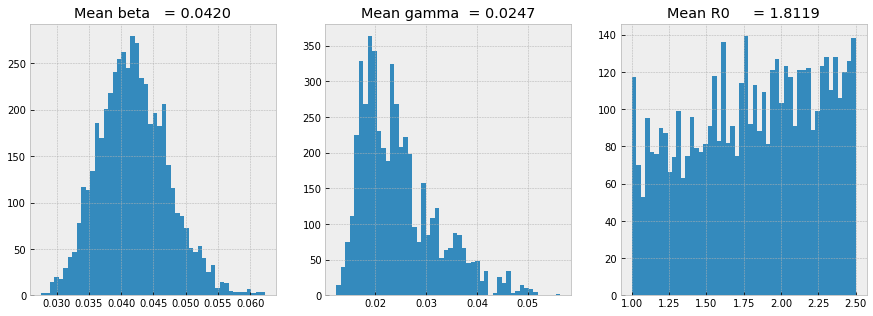

In [0]:
samples = 5000
with sir_model:
  step = pm.Metropolis()
  trace = pm.sample(samples, cores=2, step=step)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for n, data in enumerate(['beta','gamma','R0']):
  ax[n].hist(trace[data][samples:], bins=50)
  ax[n].set_title('Mean {0:6s} = {1:.4f}'.format(data, trace[data][samples:].mean()))

beta_est = trace['beta'][samples:].mean()
gamma_est = trace['gamma'][samples:].mean()

The histograms above represent the posterior distributions of the parameters of interest after processing 5000 samples from two different Metropolis sampling Markov chains. The correlation between $\beta$ and $\gamma$ can be seen due to the lack of convergence in $R0$. Samples from the posterior distribution were then passed back through the SIR model to compare against the observed values and to forecast into the future. The figures below compare infections, infection rate, and removed cases against the observed data, followed by a forecast 100 days into the future. A forecast generated with the posterior mean values is noted in red, while posterior samples are shown in grey.

In [0]:
''' These functions create SIR forecasts using posterior distributions.
The results are compared against observed data and can be forecasted out 
any number of days.
'''
def _sir_wrapper(times, initial_conditions, beta, gamma, N):
  y = odeint(SIR, y0=initial_conditions, t=times, args=((beta,gamma,N),))
  return y[:,[1,2]]

def plot_sir_forecast(yobs, trace, y0, days_out=100, posterior_samples=100):
  forecasted = days_out - len(yobs)
  N=1
  b = trace['beta'][-posterior_samples:]
  g = trace['gamma'][-posterior_samples:]

  start_date = date(2020, 4, 12)
  end_date = start_date + timedelta(len(yobs))
  end_date_prop = start_date + timedelta(days_out)

  x = [date for date in daterange(date(2020, 4, 12), end_date)]
  xp = [date for date in daterange(date(2020, 4, 12), end_date_prop)]

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

  for ii in range(100):
    y = _sir_wrapper(np.arange(0,len(xp)), y0, b[ii], g[ii], N)

    ax1.plot(xp, y[:,0], color='grey', alpha=0.35, linewidth=0.5)
    ax2.plot(xp[1:], np.diff(y[:,0]), color='grey', alpha=0.35, linewidth=0.5)
    ax3.plot(xp, y[:,1], color='grey', alpha=0.35, linewidth=0.5)
    if any(y[:,1] > 1.0):
      ax3.set_ylim(top=1.0)

  y_est = _sir_wrapper(np.arange(0,len(xp)), y0, b.mean(), g.mean(), N)

  dy_est = np.diff(y_est[:,0])

  peak = (xp[np.argmax(dy_est)])
  #zero_crossing = xp[np.where(np.diff(np.sign(dy_est)))[0]]

  ax1.plot(x, yobs[:,0], label='Observed')
  ax1.plot(xp, y_est[:,0], label='Estimate')
  ax1.set_ylabel('Percentage Infected')

  ax2.plot(x[1:], np.diff(yobs[:,0]), label='Observed')
  ax2.plot(xp[1:], dy_est, label='Estimate')

  if days_out != len(yobs):
    ax2.axvline(peak, color='k', label='Estimated Peak', linewidth=0.5)
  #if zero_crossing:
  #  ax2.axvline(zero_crossing, color='k', label='Change in Cases Below Zero', linewidt=0.5)
  ax2.set_ylabel('Daily Change in Percentage of Infected')

  ax3.plot(x, yobs[:,1], label='Observed')
  ax3.plot(xp, y_est[:,1], label='Estimate')
  ax3.set_ylabel('Percentage Removed')
  fig.autofmt_xdate()

  for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title('Forecast {} Days Beyond Observed Data'.format(forecasted))


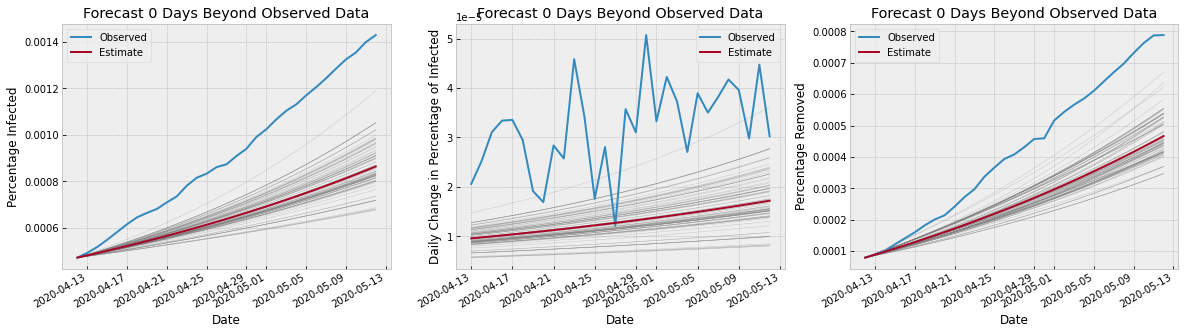

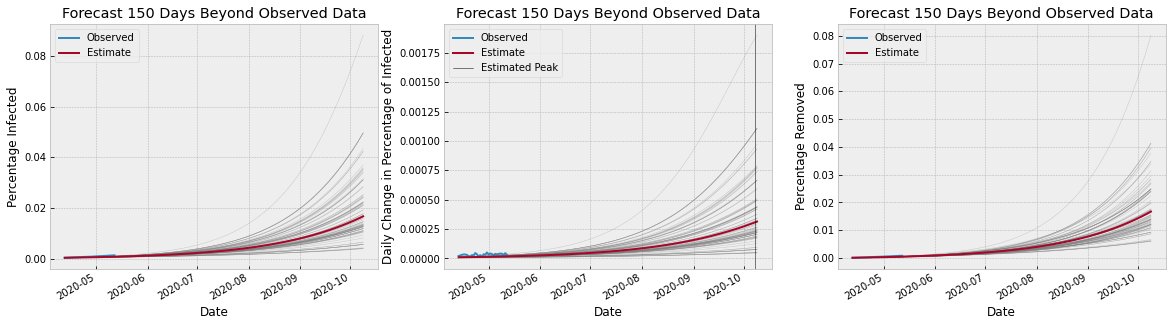

In [0]:
plot_sir_forecast(yobs, trace, y0, days_out=len(yobs))
plot_sir_forecast(yobs, trace, y0, days_out=len(yobs)+150)

According to the forecast of the simple SIR model, Texas does not reach a peak in new cases before October of 2020 with infection rates slowly increasing over the next 150 days, however, he plots show that the simple SIR model significantly underestimates the infection rate and deviates from the observed values. To attempt to improve the performance of the forecast, additional fidelity was added to the model in the form of an SEIR model.

# SEIR Estimation

To attempt to improve the performance of the model, an additional exposed compartment was added to reflect the percentage of the population that has been exposed to the virus, but has not yet become infected [8]. Death and recovered cases are additionally broken out into separate states. The differential equations governing this model are

\begin{equation*}
\frac{dS}{dt} = -\beta IS \\
\frac{dE}{dt} = \beta IS - \alpha E\\
\frac{dI}{dt} = \alpha E - (1-\delta)\gamma I - (\delta \rho I)\\
\frac{dR}{dt} = (1-\delta)\gamma I\\
\frac{dD}{dt} = \delta\rho I
\end{equation*}

where $\alpha^{-1}$ represents the average incubation period of the virus, and $\delta$ and $\rho$ are the rates of recovery and death, respectfully. From research collected so far, coronavirus has an average incubation time of five days [9]. To include this information in the prior for $\alpha$, the prior distribution for $\alpha$ was modeled as an exponential distribution with scale 1/5.

\begin{equation*}
\alpha \sim Exp(0.2)
\end{equation*}

To estimate the initial percentage of the population that was exposed to the virus, a ratio of the estimated infection rate $\beta$ and recovery rate $\alpha$ from the previous model were used to estimate a number of people that would have been exposed by those infected at time $t_0$.

$$ E_0 \approx \frac{\gamma^{-1}}{\beta^{-1}}(I_0) $$

All other priors were still assumed to be noninformative priors. Deaths and recovered cases were included in the observation model as separate observations. The hierarchy of the resulting Bayesian estimation problem is shown in the figure below.

Compiling Parameter Priors
Compiling SEIR Dynamics
Compiling Observation Models


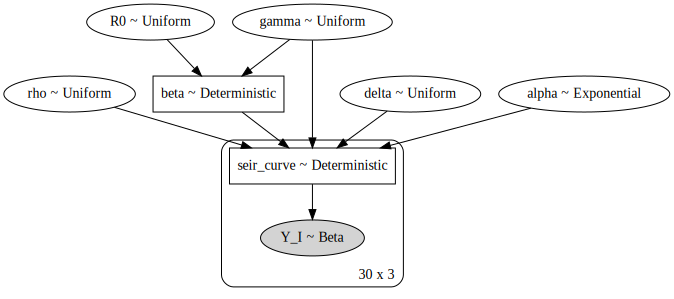

In [0]:
# Observation data converted to ndarray for PYMC
yobs = pd.DataFrame(data=[df['Confirmed'], df['Recovered'], df['Deaths']]).transpose().to_numpy(dtype='float64')
# Creating array of times from y_t0+1 to y_t
times = np.arange(1, len(yobs), step=1, dtype='float64')

# Define SIR dynamics, including "exposed" compartment
def SEIR(y, t, p):
    # p - beta, gamma, alpha, delta, rho
    beta, gamma, alpha, delta, rho = p
    S,E,I,R,D = y
    ds = -beta*(S*I)
    de = beta*S*I - (alpha)*E
    di = alpha*E - (1-delta)*(gamma)*I - delta*rho*I
    dr = (1-delta)*gamma*I
    dd = delta*rho*I
    return [ds, de, di, dr, dd]

# Theano wrapper function to pass PYMC3 samples to custom dynamics function
@theano.compile.ops.as_op(
    itypes=[tt.dvector, tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar],
    otypes=[tt.dmatrix])
def seir_wrapper(times, initial_conditions, beta, gamma, alpha, delta, rho):
  y = odeint(SEIR, y0=initial_conditions, t=times, args=((beta,gamma,alpha,delta,rho),))
  return y[:,[2, 3, 4]]


N = 1.0
(I, R, D) = yobs[0,:]
E = I*(1/gamma_est)/(1/beta_est)
S = N-(E+I+R+D)
y0 = np.array([S, E, I, R, D])

with pm.Model() as seir_model:

  print('Compiling Parameter Priors')
  R0 = pm.Uniform('R0', lower=1, upper=2)
  gamma = pm.Uniform('gamma', lower=0.01, upper=0.1)
  beta = pm.Deterministic('beta', R0*gamma)
  alpha = pm.Exponential('alpha', 0.2)
  delta = pm.Uniform('delta', lower=0, upper=1)
  rho = pm.Uniform('rho', lower=0, upper=0.5)

  print('Compiling SEIR Dynamics')
  seir_curve = pm.Deterministic('seir_curve', seir_wrapper(theano.shared(times), theano.shared(y0), beta, gamma, alpha, delta, rho))

  print('Compiling Observation Models')
  Y_I = pm.Beta('Y_I', alpha=seir_curve, beta=(1-seir_curve), observed=yobs[1::])

pm.model_to_graphviz(seir_model)

In [0]:
samples = 25000
with seir_model:
  step = pm.Metropolis()
  trace = pm.sample(samples, cores=2, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [rho]
>Metropolis: [delta]
>Metropolis: [alpha]
>Metropolis: [gamma]
>Metropolis: [R0]
Sampling 2 chains, 0 divergences: 100%|██████████| 51000/51000 [31:55<00:00, 26.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


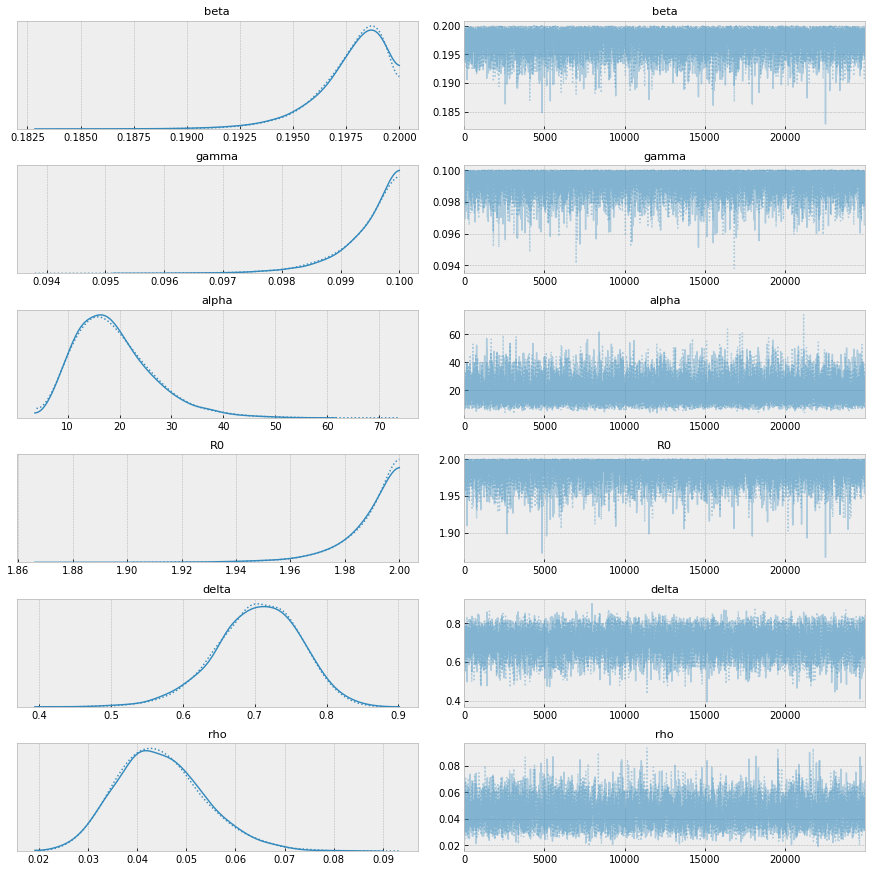

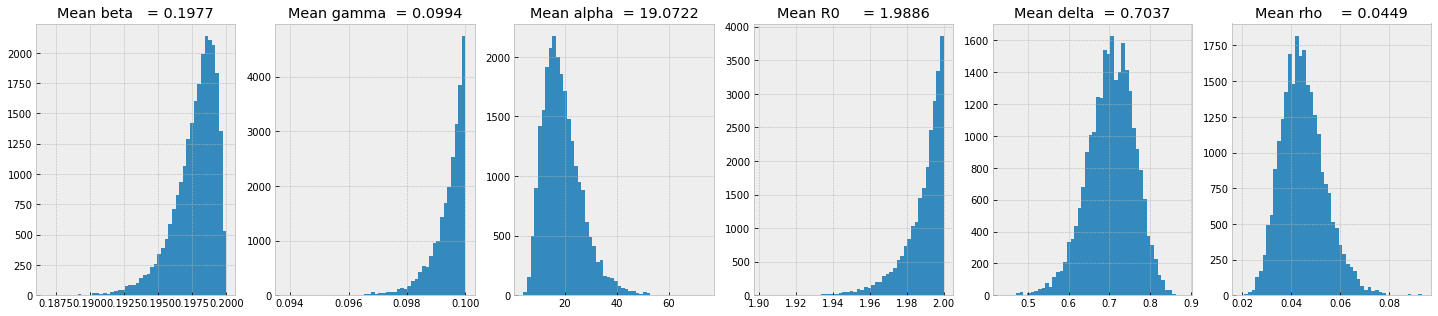

In [0]:
keys = ['beta','gamma','alpha','R0','delta','rho']
tp = pm.traceplot(trace, var_names=keys)

fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(25,5))

for n, data in enumerate(keys):
  ax[n].hist(trace[data][samples:], bins=50)
  ax[n].set_title('Mean {0:6s} = {1:.4f}'.format(data, trace[data][samples:].mean()))

In [0]:
''' These functions create SEIR forecasts using posterior distributions.
The results are compared against observed data and can be forecasted out 
any number of days.
'''
def _seir_wrapper(times, initial_conditions, beta, gamma, alpha, delta, rho):
  y = odeint(SEIR, y0=initial_conditions, t=times, args=((beta,gamma,alpha,delta,rho),))
  return y[:,2:]

def plot_seir_forecast(yobs, trace, y0, days_out=100, posterior_samples=100):
  posterior_samples = 250
  forecasted = days_out - len(yobs)
  b = trace['beta'][-posterior_samples:]
  g = trace['gamma'][-posterior_samples:]
  a = trace['alpha'][-posterior_samples:]
  d = trace['delta'][-posterior_samples:]
  rho = trace['rho'][-posterior_samples:]

  start_date = date(2020, 4, 12)
  end_date = start_date + timedelta(len(yobs))
  end_date_prop = start_date + timedelta(days_out)

  x = [date for date in daterange(date(2020, 4, 12), end_date)]
  xp = [date for date in daterange(date(2020, 4, 12), end_date_prop)]

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

  for ii in range(100):
    y = _seir_wrapper(np.arange(0,len(xp)), y0, b[ii], g[ii], a[ii], d[ii], rho[ii])

    ax1.plot(xp, y[:,0], color='grey', alpha=0.35, linewidth=0.5)
    ax2.plot(xp[1:], np.diff(y[:,0]), color='grey', alpha=0.35, linewidth=0.5)
    ax3.plot(xp, y[:,1]+y[:,2], color='grey', alpha=0.35, linewidth=0.5)
    if any(y[:,1] > 1.0):
      ax3.set_ylim(top=1.0)

  y_est = _seir_wrapper(np.arange(0,len(xp)), y0, b.mean(), g.mean(), a.mean(), d.mean(), rho.mean())

  dy_est = np.diff(y_est[:,0])

  peak = (xp[np.argmax(dy_est)])
  #zero_crossing = xp[np.where(np.diff(np.sign(dy_est)))[0]]

  ax1.plot(x, yobs[:,0], label='Observed')
  ax1.plot(xp, y_est[:,0], label='Estimate')
  ax1.set_ylabel('Percentage Infected')

  ax2.plot(x[1:], np.diff(yobs[:,0]), label='Observed')
  ax2.plot(xp[1:], dy_est, label='Estimate')

  if days_out != len(yobs):
    ax2.axvline(peak, color='k', label='Estimated Peak', linewidth=0.5)
  #if zero_crossing:
  #  ax2.axvline(zero_crossing, color='k', label='Change in Cases Below Zero', linewidt=0.5)
  ax2.set_ylabel('Daily Change in Percentage of Infected')

  ax3.plot(x, yobs[:,1]+yobs[:,2], label='Observed')
  ax3.plot(xp, y_est[:,1]+y_est[:,2], label='Estimate')
  ax3.set_ylabel('Percentage Removed')
  fig.autofmt_xdate()

  for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title('Forecast {} Days Beyond Observed Data'.format(forecasted))


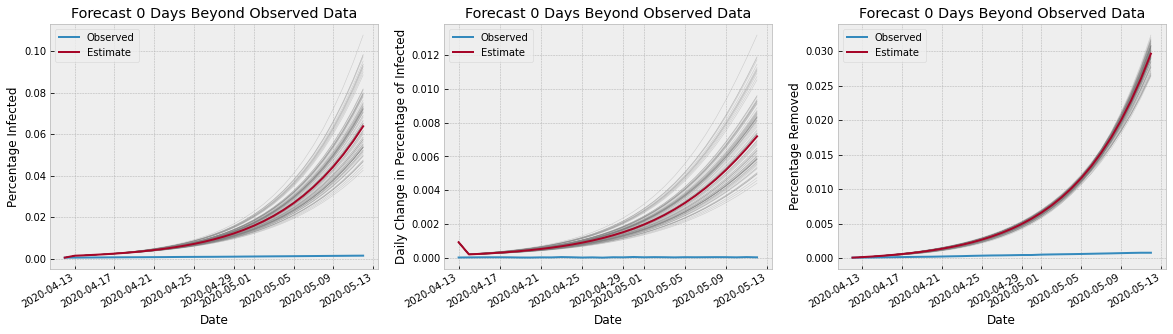

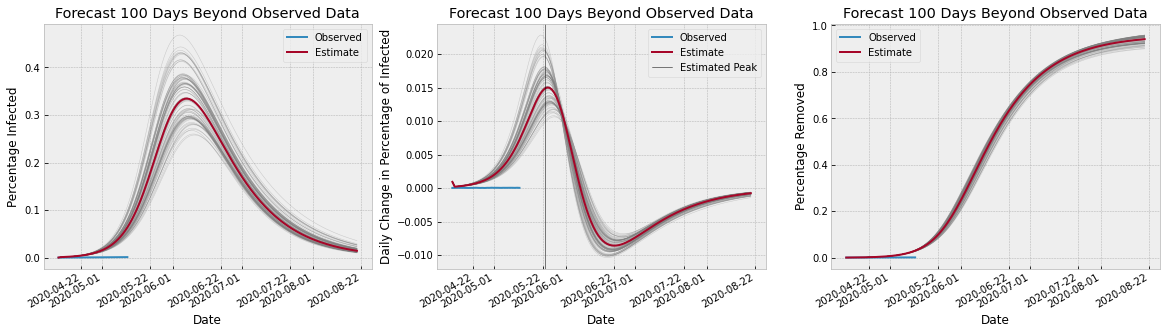

In [0]:
plot_seir_forecast(yobs, trace, y0, days_out=len(yobs), posterior_samples=100)
plot_seir_forecast(yobs, trace, y0, days_out=len(yobs)+100, posterior_samples=100)

For the SEIR model, the posterior values signficantly overestimate the infection and recovery rates of the system, prediciting a peak in new cases occuring in late May and deviating largely from the observed values. It is apparent that additional refinements could be made to improve this model as well.

# Conclusions and Future Work

This analysis presented a probabilistic approach to modeling the dynamics of coronavirus infection. The Markov property can be utilized to sample prior distributions of system parameters and improve estimates.

The most obvious improvments to the models presented are better selections in prior distributions. If more informed priors are not available, more data, either through more recorded days or through curve fitting estimates, could potentially be used to improve the performance of the MCMC algorithm.

# References

[1] Kermack, W. O.; McKendrick, A. G. (1927). "A Contribution to the Mathematical Theory of Epidemics". Proceedings of the Royal Society A. 115 (772): 700–721

[2] Z. Feng. Final and peak epidemic sizes for SEIR models with quarantine and isolation. Mathematical Biosciences and Engineering, 2007, 4(4): 675-686. doi: 10.3934/mbe.2007.4.675

[3] Longini, I. Clark, S., et al. Statistical Analysis of the Stages of HIV Infection Using a Markov Model. 1989. Statistics in Medicine, Vol. 8. 831-843.

[4] Gallager, R. Stochastic Processes: Theory for Applications. Cambridge University Press.

[5] Davidson-Pilon, C. Probabilistic Programming and Bayesian Methods for Hackers. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

[6] http://www.public.asu.edu/~hnesse/classes/seir.html. Accessed 5/12/2020.

[7] Wang, L. An epidemiological forecast model and software assessing interventions on COVID-19 epidemic in China. Pre-print. https://doi.org/10.1101/2020.02.29.20029421

[8] Aron, J.L, Schwartz, I.B, "Seasonality and period-doubling bifurcations in an epidemic model." Journal of Theoretical Biology. 110:665-679. 1984

[9] Lauer SA, Grantz KH, Bi Q, et al. The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application. Annals of Internal Medicine. https://doi.org/10.7326/M20-0504